In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds


TensorFlow 2.x selected.
Tensorflow version 2.1.0
Running on TPU  ['10.69.149.66:8470']
INFO:tensorflow:Initializing the TPU system: 10.69.149.66:8470


INFO:tensorflow:Initializing the TPU system: 10.69.149.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [0]:
def get_dataset(batch_size=200):
  datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True,
                             try_gcs=True)
  mnist_train, mnist_test = datasets['train'], datasets['test']

  def scale(image,label):
    image = tf.cast(image, tf.float32)
    image /= 255.0

    return image, image

  train_dataset = mnist_train.map(scale).shuffle(10000).batch(batch_size,drop_remainder=True)
  test_dataset = mnist_test.map(scale).batch(batch_size,drop_remainder=True)

  return train_dataset, test_dataset
train_dataset,test_dataset = get_dataset(128*8)

In [3]:
with tpu_strategy.scope():
    autoencoder = tf.keras.Sequential([layers.Conv2D(16, 3, activation='relu',input_shape=(28, 28, 1)),
                                     layers.Conv2D(32, 3, activation='relu'),
                                     layers.MaxPooling2D(3),
                                     layers.Conv2D(32, 3, activation='relu'),
                                     layers.Conv2D(16, 3, activation='relu'),
                                     layers.GlobalMaxPooling2D(),
                                     layers.Reshape((4, 4, 1)),
                                     layers.Conv2DTranspose(16, 3, activation='relu'),
                                     layers.Conv2DTranspose(32, 3, activation='relu'),
                                     layers.UpSampling2D(3),
                                     layers.Conv2DTranspose(16, 3, activation='relu'),
                                     layers.Conv2DTranspose(1, 3, activation='relu')])
    autoencoder.summary()
    autoencoder.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
autoencoder.fit(train_dataset, epochs=45,validation_data=test_dataset)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 1)           0

In [4]:
def get_dataset2():
  datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True,
                             try_gcs=True)
  mnist_train, mnist_test = datasets['train'], datasets['test']

  def scale(image,label):
    image = tf.cast(image, tf.float32)
    image /= 255.0

    return image

  test_dataset = mnist_test.map(scale)

  return test_dataset
x_test = get_dataset2().batch(1000,drop_remainder=True).take(1)
predictions = autoencoder.predict(x_test)
print(predictions.shape)

(1000, 28, 28, 1)


In [5]:
x_test= next(iter(x_test))
x_test = x_test.numpy()
print(predictions[:,:,:,0].shape)

(1000, 28, 28)


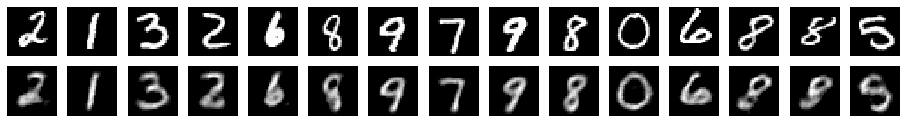

In [11]:
fig, axes1 = plt.subplots(2,15,figsize=(16,2))
for k in range(15):
    i = np.random.choice(range(len(x_test)))
    for j in range(2):
        axes1[j][k].set_axis_off()
        if j==0 :
            axes1[j][k].imshow(x_test[i,:,:,0], cmap='gray')
        else:
            axes1[j][k].imshow(predictions[i,:,:,0], cmap='gray')